In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from lifelines import KaplanMeierFitter
from myworkspaceutils.surv import SurvHelper

from pathlib import Path
current_dir = Path.cwd()
data_dir = f'{current_dir.parent.parent}/data/ct_based_radio_genomics__'

In [2]:
clinical_df = pd.read_csv(f"{data_dir}/cleaned_clinical.csv")
radiomics_df = pd.read_csv(f"{data_dir}/cleaned_radio.csv")
genomics_df = pd.read_csv(f"{data_dir}/cleaned_rna.csv")
print(f"Dataset shapes: Clinical: {clinical_df.shape} Radiomics: {radiomics_df.shape} Genomics: {genomics_df.shape}")

Dataset shapes: Clinical: (113, 6) Radiomics: (113, 11) Genomics: (113, 12)


In [3]:
clinical_df.columns

Index(['patient_id', 'event', 'os', 'gender', 'recurrence_metastasis',
       'treatment_response'],
      dtype='object')

In [4]:
radiomics_df.columns

Index(['patient_id', 'event', 'os',
       'image_lbp-3D-k_glrlm_RunLengthNonUniformity',
       'image_wavelet-HHH_glszm_ZoneEntropy',
       'image_wavelet-LLL_glcm_DifferenceEntropy',
       'image_wavelet-HLH_gldm_SmallDependenceLowGrayLevelEmphasis',
       'image_lbp-2D_firstorder_Kurtosis', 'image_square_glcm_MCC',
       'image_wavelet-HLL_glcm_InverseVariance',
       'image_square_firstorder_InterquartileRange'],
      dtype='object')

In [5]:
genomics_df.columns

Index(['patient_id', 'event', 'os', 'CDKN2A-AS1', 'ANXA8', 'LINC01504', 'RGS5',
       'SPRYD7', 'KCNK15-AS1', 'TRAV10', 'RP11-466A19.8', 'RNAsignature'],
      dtype='object')

### Merging all three modalities in a single DataFrame

In [6]:
 def merge_dfs(df1, df2, on_cols): 
    merged = df1.merge(df2, on=on_cols, how='inner')
    print(f"Merged {len(merged)} patients (from {len(df1)} and {len(df2)})")
    return merged
 
temp_merged = merge_dfs(
    clinical_df, 
    radiomics_df, 
    ['patient_id', 'os', 'event']
)

multi_omics_df = merge_dfs(
    temp_merged,
    genomics_df,
    ['patient_id', 'os', 'event'] 
)

print(f"Multiomic dataset: {multi_omics_df.shape}")
# Should match your 115 matched patients

Merged 113 patients (from 113 and 113)
Merged 113 patients (from 113 and 113)
Multiomic dataset: (113, 23)


In [7]:
multi_omics_df.shape

(113, 23)

In [8]:
multi_omics_df.columns

Index(['patient_id', 'event', 'os', 'gender', 'recurrence_metastasis',
       'treatment_response', 'image_lbp-3D-k_glrlm_RunLengthNonUniformity',
       'image_wavelet-HHH_glszm_ZoneEntropy',
       'image_wavelet-LLL_glcm_DifferenceEntropy',
       'image_wavelet-HLH_gldm_SmallDependenceLowGrayLevelEmphasis',
       'image_lbp-2D_firstorder_Kurtosis', 'image_square_glcm_MCC',
       'image_wavelet-HLL_glcm_InverseVariance',
       'image_square_firstorder_InterquartileRange', 'CDKN2A-AS1', 'ANXA8',
       'LINC01504', 'RGS5', 'SPRYD7', 'KCNK15-AS1', 'TRAV10', 'RP11-466A19.8',
       'RNAsignature'],
      dtype='object')

In [9]:
surv = SurvHelper(multi_omics_df)

## Non Parametric Analysis

Non Parameteric analysis is same as in `02. CoxPh-Clinical` Notebook

## Semi-parametric Analysis (CoxPhFitter)

Using CoxPhFitter from lifelines for analyzing hazard ratio..

Interpretation of Hazard Ratios (HR):

- HR = 1: No effect on survival
- HR > 1: Increased risk of death (worse prognosis)
- HR < 1: Decreased risk of death (better prognosis)


In [10]:
predictor_columns = list(multi_omics_df.columns.values[3:])

In [11]:
predictor_columns

['gender',
 'recurrence_metastasis',
 'treatment_response',
 'image_lbp-3D-k_glrlm_RunLengthNonUniformity',
 'image_wavelet-HHH_glszm_ZoneEntropy',
 'image_wavelet-LLL_glcm_DifferenceEntropy',
 'image_wavelet-HLH_gldm_SmallDependenceLowGrayLevelEmphasis',
 'image_lbp-2D_firstorder_Kurtosis',
 'image_square_glcm_MCC',
 'image_wavelet-HLL_glcm_InverseVariance',
 'image_square_firstorder_InterquartileRange',
 'CDKN2A-AS1',
 'ANXA8',
 'LINC01504',
 'RGS5',
 'SPRYD7',
 'KCNK15-AS1',
 'TRAV10',
 'RP11-466A19.8',
 'RNAsignature']

In [12]:
cph = surv.fit_coxph(predictor_columns)

In [13]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
gender,0.336833,1.400505,0.244139,-0.141671,0.815337,0.867907,2.259937,0.0,1.379676,0.167686,2.576163
recurrence_metastasis,0.189172,1.208249,0.218622,-0.239318,0.617663,0.787164,1.854589,0.0,0.865296,0.386876,1.370055
treatment_response,-0.724855,0.484395,0.221661,-1.159303,-0.290407,0.313705,0.747959,0.0,-3.270103,0.001075,9.861334
image_lbp-3D-k_glrlm_RunLengthNonUniformity,4.167699,64.566731,1.515254,1.197856,7.137542,3.313008,1258.331811,0.0,2.750496,0.005951,7.392770
image_wavelet-HHH_glszm_ZoneEntropy,1.061973,2.892071,2.173886,-3.198766,5.322712,0.040813,204.938824,0.0,0.488514,0.625186,0.677642
image_wavelet-LLL_glcm_DifferenceEntropy,-0.654493,0.519705,1.546629,-3.685830,2.376843,0.025076,10.770845,0.0,-0.423174,0.672168,0.573106
image_wavelet-HLH_gldm_SmallDependenceLowGrayLevelEmphasis,-0.125925,0.881681,1.852581,-3.756917,3.505068,0.023356,33.283698,0.0,-0.067973,0.945807,0.080382
image_lbp-2D_firstorder_Kurtosis,1.239306,3.453216,1.360265,-1.426765,3.905377,0.240084,49.668779,0.0,0.911077,0.362255,1.464923
image_square_glcm_MCC,-0.751760,0.471536,0.534748,-1.799846,0.296326,0.165324,1.344909,0.0,-1.405822,0.159777,2.645868


<Axes: xlabel='log(HR) (95% CI)'>

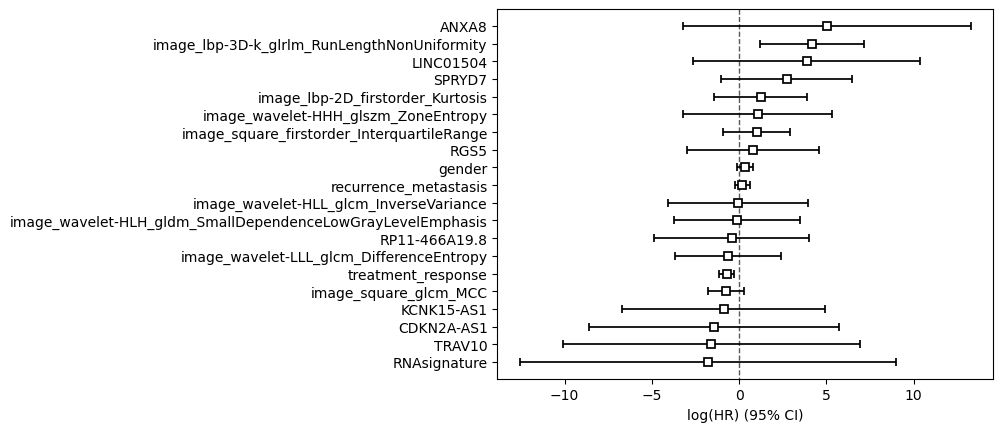

In [14]:
# Plot the results
cph.plot()

| Modality | Feature | Combined Model HR | Individual Model HR | Change | Significance | Key Insight |
|----------|---------|------------------|---------------------|---------|--------------|------------|
| **Clinical** | Treatment Response | 0.48 | 0.40 | Weaker | p = 0.001 | Still significant but effect reduced |
| **Clinical** | Recurrence/Metastasis | 1.21 | 1.34 | Weaker | p = 0.387 | Lost significance in combined model |
| **Radiomics** | RunLengthNonUniformity | 64.57 | 8.77 | **7.4x Stronger** | p = 0.006 | Dominant predictor in combined model |
| **Genomics** | ANXA8 | 152.54 | 56.38 | More Extreme | p = 0.232 | Still unreliable, massive CIs |
| **Genomics** | All Genes | Wide CIs | Wide CIs | No Improvement | All p > 0.15 | Persistent overfitting issues |

## Summary of Changes:
- **Radiomics emerged** as the most powerful modality when features compete
- **Clinical features weakened** as they share predictive power with radiomics  
- **Genomics remained unstable** despite multi-modal integration
- **RunLengthNonUniformity** appears to capture fundamental tumor aggression